In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import Conv3D, MaxPool3D
from tensorflow.keras.utils import plot_model
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import numpy as np
import cv2 as cv
import pickle

In [2]:
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
# Load from the pickle file
with open('data/train/processed/SIFT_data.pkl', 'rb') as file:
    sift_data = pickle.load(file)

# Load from the pickle file
with open('data/train/processed/resized_data.pkl', 'rb') as file:
    raw_data = pickle.load(file)

    # Load from the pickle file
with open('data/train/processed/SIFT_labels.pkl', 'rb') as file:
    sift_labels = pickle.load(file)

# Load from the pickle file
with open('data/train/processed/resized_labels.pkl', 'rb') as file:
    raw_labels = pickle.load(file)

# recall the labels
# 0 = clean
# 1 = dirty


In [4]:
# double check the shapes
print(np.shape(sift_data))
print(np.shape(sift_labels))
print(np.shape(raw_data))
print(np.shape(raw_labels))

# Note the sift data will be shorter because we deleted elements that rendered 0 sift keypoints
# Note the lengths should match between each list of features/labels

(788, 2, 1163, 128)
(788,)
(792, 278, 348)
(792,)


In [5]:
# Used these wghile building the models
# test = raw_data[:5]+raw_data[-5:]
# test_labels = raw_labels[:5]+raw_labels[-5:]

# test_s = sift_data[:5]+sift_data[-5:]
# test_labels_s = sift_labels[:5]+sift_labels[-5:]

In [6]:
# make a test train split
x_train, x_test, y_train, y_test = train_test_split(raw_data, raw_labels, test_size=0.20, random_state=42)
# make a test train split
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(sift_data, sift_labels, test_size=0.20, random_state=42)


In [7]:
# for minimally processed images
# check the shape again after split
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))

# now we reshape y to match what is expected
y_train = np.array(y_train).reshape(-1)
y_test = np.array(y_test).reshape(-1)

print(np.shape(y_train))
print(np.shape(y_test))


(633, 278, 348)
(633,)
(159, 278, 348)
(159,)
(633,)
(159,)


In [8]:
# for sift data
# check the shape again after split
print(np.shape(x_train_s))
print(np.shape(y_train_s))
print(np.shape(x_test_s))
print(np.shape(y_test_s))

# now we reshape y to match what is expected
y_train_s = np.array(y_train_s).reshape(-1)
y_test_s = np.array(y_test_s).reshape(-1)

print(np.shape(y_train_s))
print(np.shape(y_test_s))

(630, 2, 1163, 128)
(630,)
(158, 2, 1163, 128)
(158,)
(630,)
(158,)


In [9]:
# Define how many epochs to use for both models
n_epochs = 6

In [10]:
# Now you'll build a CNN with a few layers as detailed below
#
# The CNN will have a very basic design
# [Input(),
#  Conv2D(),
#  MaxPool2D(),
#  Conv2D(),
#  MaxPool2D(),
#  Flatten(),
#  Dense()]

cnn_layers = []
cnn_layers.append(keras.layers.Input(shape=(278, 348, 1)))
cnn_layers.append(keras.layers.Conv2D(3, 3, activation='relu')) # very basic kernel
cnn_layers.append(keras.layers.MaxPool2D()) # default pooling layer
cnn_layers.append(keras.layers.Conv2D(3, 3, activation='relu')) # another basic kernel
cnn_layers.append(keras.layers.MaxPool2D())# default pooling layer
cnn_layers.append(keras.layers.Flatten()) # default flatteing layer
cnn_layers.append(keras.layers.Dense(1, activation='sigmoid')) # 1 because it is binary classification


cnn_model = keras.Sequential(cnn_layers)


cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 276, 346, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 138, 173, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 136, 171, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 68, 85, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 17340)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        17,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,455 (68.18 KB)

 Trainable params: 17,455 (68.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.5626 - loss: 83.9929 - val_accuracy: 0.8239 - val_loss: 8.2249
Epoch 2/6
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.8349 - loss: 8.1099 - val_accuracy: 0.7296 - val_loss: 6.9527
Epoch 3/6
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.8681 - loss: 3.9575 - val_accuracy: 0.8931 - val_loss: 2.9788
Epoch 4/6
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9200 - loss: 1.6458 - val_accuracy: 0.8491 - val_loss: 2.9909
Epoch 5/6
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9201 - loss: 1.0998 - val_accuracy: 0.8931 - val_loss: 2.1502
Epoch 6/6
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9469 - loss: 0.7409 - val_accuracy: 0.8742 - val_loss: 2.1472

Accuracy on the final epoch of training was 95.58%


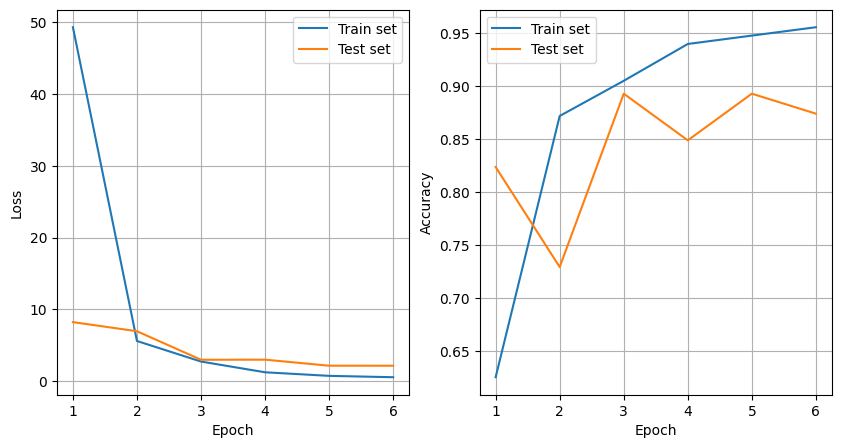

In [11]:
# Now we'll train the CNN model with raw data

# In our case the " raw data " is minimally processed images
# Due to the arch limiatations, all images have to be the same size, so we resized
#   some and also turned to greyscale
#
# 
#
# Also, the model expects the input samples to have a "channel" dimension, e.g.,
# three channels (red/green/blue) for color images, 1 channel for grayscale images.
# So we reshape the data to have an additional channel dim 
#
# Note that we used 'binary_crossentropy' as the loss function given the task were doing

cnn_model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])


history = cnn_model.fit(np.array(x_train).reshape(-1, 278, 348 ,1), y_train, epochs=n_epochs,
                        validation_data=(np.array(x_test).reshape(-1, 278, 348 ,1), y_test))


# this makes a nice plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, n_epochs+1), history.history['loss'], label='Train set')
plt.plot(np.arange(1, n_epochs+1), history.history['val_loss'], label='Test set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, n_epochs+1), history.history['accuracy'], label='Train set')
plt.plot(np.arange(1, n_epochs+1), history.history['val_accuracy'], label='Test set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
print(f"\nAccuracy on the final epoch of training was {100*history.history['accuracy'][-1]:0.2f}%")

In [12]:
# Now we'll train the CNN model with the sift data
#
# As before, the model expects the input samples to have a "channel" dimension, e.g.,
# three channels (red/green/blue) for color images, 1 channel for grayscale images.
# Very important: We have to transpose our original data shape to have the channel dimension
# last, which will allow us to use the 2d architecture even with this multidimensional data.
#
# Note that we also used 'binary_crossentropy' as the loss function given the task were doing

# Build the CNN model
cnn_model_sift = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(1163, 128, 2)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Display the model's architecture
cnn_model_sift.summary()

/Users/imac/Projects/DirtyDishNeuralNetwork/dirty-dish-neural-network/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 1161, 126, 32)  │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 580, 63, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 578, 61, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 289, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 287, 28, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 143, 14, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    32,800,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,893,985 (125.48 MB)

 Trainable params: 32,893,985 (125.48 MB)

 Non-trainable params: 0 (0.00 B)

(630, 1163, 128, 2)
(158, 1163, 128, 2)
(630,)
(158,)
Epoch 1/6
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.5655 - loss: 892775.0000 - val_accuracy: 0.5190 - val_loss: 240.3245
Epoch 2/6
20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.6611 - loss: 112.8222 - val_accuracy: 0.6013 - val_loss: 4.9335
Epoch 3/6
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.7147 - loss: 3.0120 - val_accuracy: 0.7278 - val_loss: 1.5326
Epoch 4/6
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.7577 - loss: 0.6649 - val_accuracy: 0.7278 - val_loss: 1.1521
Epoch 5/6
20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.7185 - loss: 0.7956 - val_accuracy: 0.7278 - val_loss: 1.1542
Epoch 6/6
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.7176 - loss: 1.7775 - val_accuracy: 0.7342 - val_loss: 0.6706

Accuracy on the final epoch of training was 73.81%


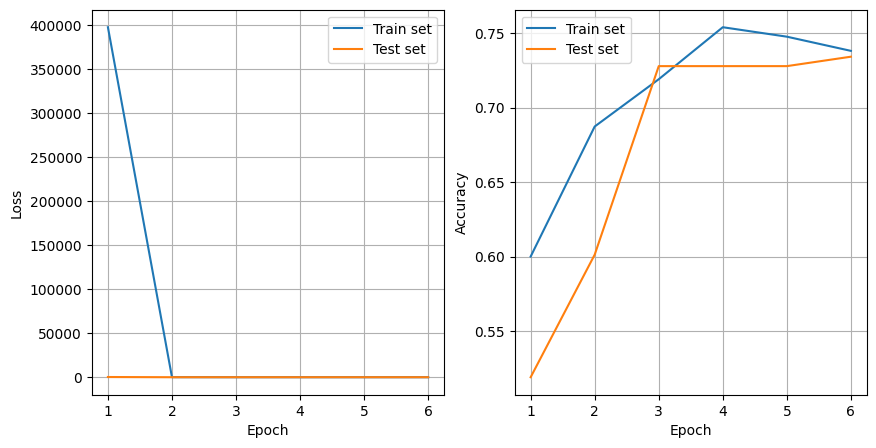

In [13]:
# Transpose data to 'channels_last' format: (num_samples, 1163, 128, 2)
x_train_ss = np.array(x_train_s).transpose(0, 2, 3, 1)
x_test_ss = np.array(x_test_s).transpose(0, 2, 3, 1)

print(np.shape(x_train_ss))
print(np.shape(x_test_ss))
print(np.shape(y_train_s))
print(np.shape(y_test_s))

# Define the input shape for the model
input_shape = (1163, 128, 2)

# Compile the model
cnn_model_sift.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
# model.fit(X, y, epochs=10, batch_size=8, validation_split=0.1)
history = cnn_model_sift.fit(np.squeeze(x_train_ss), y_train_s, epochs=n_epochs,
                         validation_data=(np.squeeze(x_test_ss), y_test_s))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, n_epochs+1), history.history['loss'], label='Train set')
plt.plot(np.arange(1, n_epochs+1), history.history['val_loss'], label='Test set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, n_epochs+1), history.history['accuracy'], label='Train set')
plt.plot(np.arange(1, n_epochs+1), history.history['val_accuracy'], label='Test set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
print(f"\nAccuracy on the final epoch of training was {100*history.history['accuracy'][-1]:0.2f}%")

In [14]:
# Let's assess our CNN model's performance on the test set
cnn_scores = cnn_model.evaluate(np.array(x_test).reshape(-1, 278, 348 ,1), y_test)

print(f"\nThe CNN model with minimally processed data achieves an accuracy of {cnn_scores[1]*100:.2f}% on the test data.")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8582 - loss: 2.1881

The CNN model with minimally processed data achieves an accuracy of 87.42% on the test data.


In [15]:
# Let's assess our CNN model's performance on the test set
cnn_scores_s = cnn_model_sift.evaluate(np.squeeze(x_test_ss), y_test_s)

print(f"\nThe CNN model with sift data achieves an accuracy of {cnn_scores_s[1]*100:.2f}% on the test data.")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 591ms/step - accuracy: 0.7074 - loss: 0.7692

The CNN model with sift data achieves an accuracy of 73.42% on the test data.


In [16]:
# For my case, it turns out applying SIFT to the data (in the way I applied it) actually made several things worse.
# For one the model took a lot longer to train
# Also, the model's max(accuracy) was a lot lower than the other model's max(accuracy) without SIFT

# So we retrain the model with the best number of epochs (5 in my case)

cnn_model_best = keras.Sequential(cnn_layers)
cnn_model_best.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
cnn_model_best.fit(np.array(x_train).reshape(-1, 278, 348 ,1), y_train, epochs=5,
                        validation_data=(np.array(x_test).reshape(-1, 278, 348 ,1), y_test))

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.7233 - loss: 10.3610 - val_accuracy: 0.8805 - val_loss: 2.4588
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.8951 - loss: 1.4933 - val_accuracy: 0.8491 - val_loss: 1.8784
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.9597 - loss: 0.2354 - val_accuracy: 0.8553 - val_loss: 1.6954
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.9744 - loss: 0.1268 - val_accuracy: 0.8553 - val_loss: 1.6601
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.9771 - loss: 0.1065 - val_accuracy: 0.8491 - val_loss: 1.6984


In [17]:
# And now we save model to file
cnn_model_best.save('data/models/cnn_model.keras')

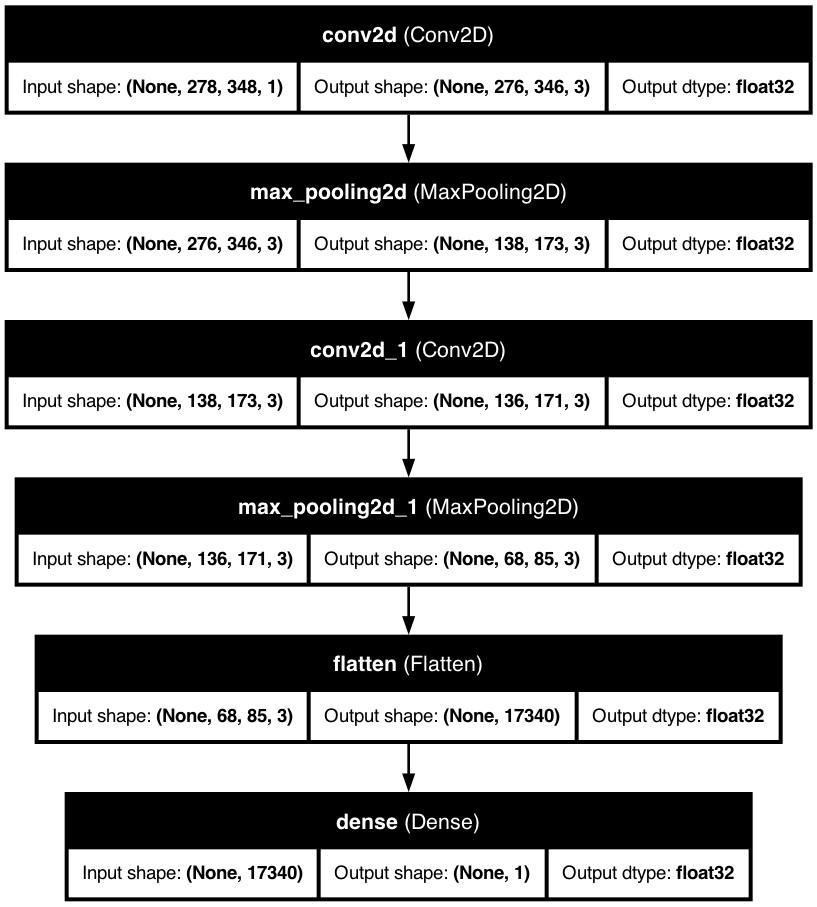

In [ ]:
# Plot the model architecture for model 1
plot_model(
    cnn_model,
    # to_file='model_architecture.png',  # Save the plot as an image
    show_shapes=True,  # Display layer output shapes
    show_dtype=True,   # Display data types of layer outputs
    show_layer_names=True,  # Show the names of the layers
    rankdir='TB',  # Top to Bottom; use 'LR' for Left to Right
    dpi=96  # Adjust the resolution
)

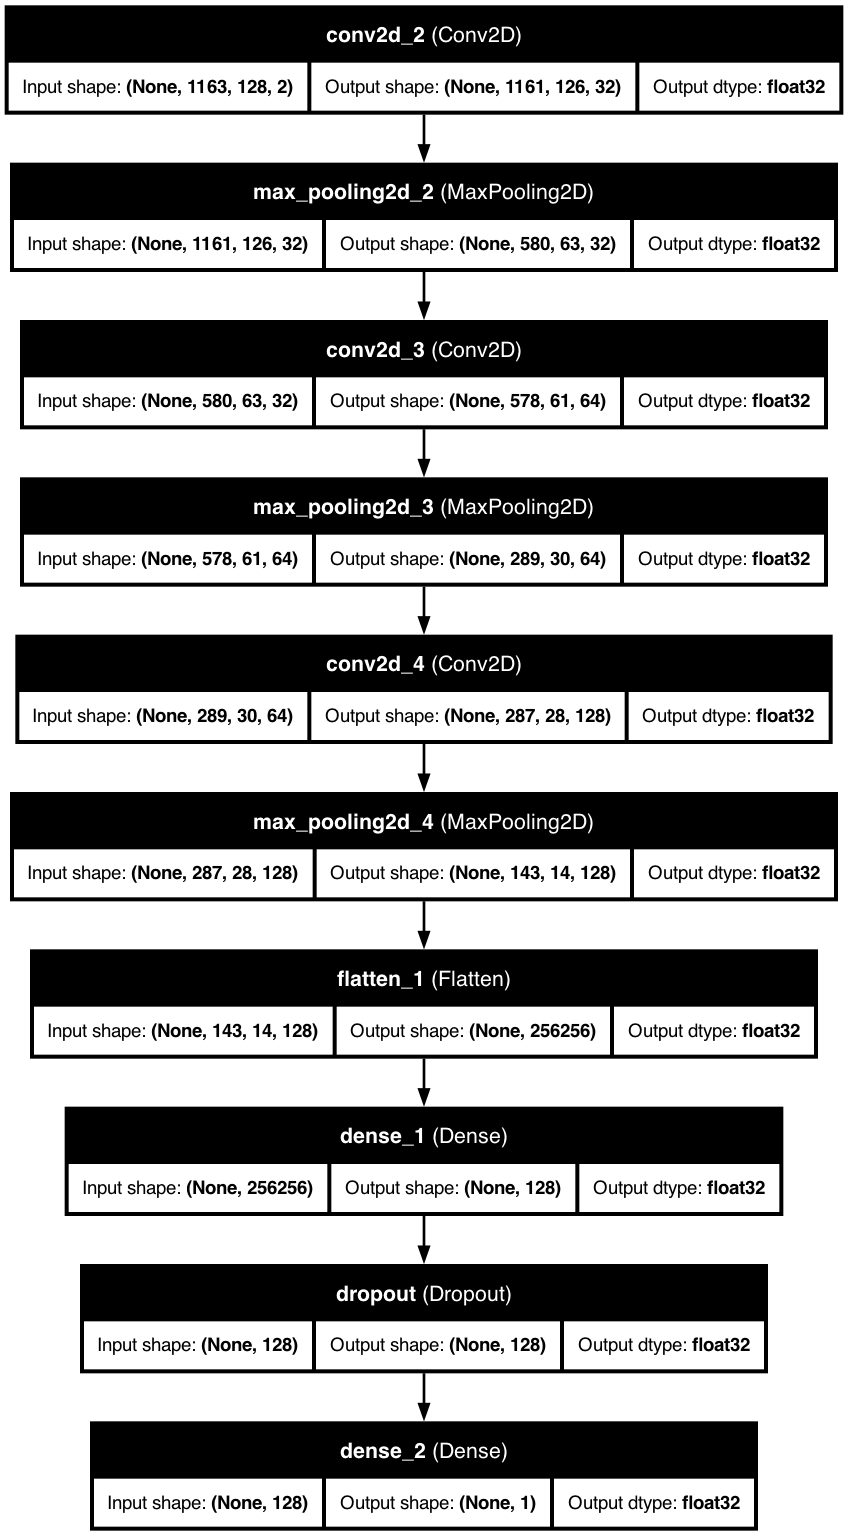

In [ ]:
# Plot the model architecture for model 2
plot_model(
    cnn_model_sift,
    # to_file='model_architecture.png',  # Save the plot as an image
    show_shapes=True,  # Display layer output shapes
    show_dtype=True,   # Display data types of layer outputs
    show_layer_names=True,  # Show the names of the layers
    rankdir='TB',  # Top to Bottom; use 'LR' for Left to Right
    dpi=96  # Adjust the resolution
)